## Test pytorch modeling before moving to scripts

In [1]:
import torch
import torch.utils.data
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
%matplotlib inline
import joblib
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
train_clean = joblib.load('data/train_clean.pckl')
test_clean = joblib.load('data/test_clean.pckl')
vectorizer = joblib.load('pytorch/vectorizer.pckl')
splits = joblib.load('pytorch/splits.pckl')

In [3]:
def get_loader(split):
    
    idx = [i for i, x in enumerate(splits) if x==0]
    
    # subset training data and target on idx_list
    X = train_clean.loc[idx, 'clean_text'].copy()
    y = train_clean.loc[idx, 'toxic'].copy()
    
    # transform to dense tfidf matrix
    X_bow = csr_matrix(vectorizer.transform(X), dtype=np.float32).todense()
    
    # create tensor dataset
    X_tensor = torch.from_numpy(X_bow)
    y_tensor = torch.LongTensor([int(x) for x in y])
    
    split_set = torch.utils.data.TensorDataset(X_tensor, y_tensor)

    # return dataloader
    return(torch.utils.data.DataLoader(split_set, batch_size=100, shuffle=False, num_workers=2))

In [4]:
[i for i, x in enumerate(splits) if x==0]


[8,
 0,
 4,
 2,
 13,
 1,
 5,
 12,
 9,
 4,
 2,
 3,
 4,
 6,
 10,
 12,
 12,
 11,
 13,
 7,
 14,
 8,
 12,
 15,
 10,
 2,
 11,
 11,
 2,
 13,
 11,
 12,
 2,
 15,
 12,
 12,
 15,
 3,
 5,
 15,
 5,
 13,
 15,
 4,
 10,
 9,
 11,
 6,
 10,
 11,
 4,
 6,
 14,
 14,
 5,
 2,
 3,
 1,
 11,
 13,
 13,
 6,
 8,
 14,
 15,
 8,
 12,
 11,
 8,
 7,
 13,
 13,
 3,
 14,
 1,
 9,
 2,
 13,
 3,
 13,
 8,
 12,
 3,
 11,
 10,
 12,
 8,
 4,
 7,
 1,
 4,
 5,
 3,
 8,
 7,
 6,
 14,
 3,
 11,
 4,
 13,
 7,
 13,
 2,
 5,
 5,
 11,
 7,
 2,
 15,
 0,
 10,
 14,
 14,
 11,
 7,
 11,
 0,
 5,
 0,
 11,
 0,
 5,
 13,
 4,
 4,
 10,
 2,
 0,
 4,
 11,
 5,
 5,
 0,
 11,
 13,
 14,
 4,
 10,
 0,
 7,
 9,
 3,
 14,
 14,
 3,
 11,
 2,
 5,
 3,
 2,
 5,
 1,
 13,
 13,
 15,
 8,
 14,
 6,
 5,
 3,
 12,
 6,
 11,
 0,
 2,
 2,
 14,
 5,
 9,
 10,
 9,
 11,
 10,
 8,
 4,
 3,
 14,
 10,
 1,
 1,
 3,
 13,
 1,
 0,
 12,
 7,
 5,
 11,
 4,
 14,
 15,
 13,
 1,
 7,
 8,
 14,
 1,
 11,
 8,
 4,
 13,
 9,
 0,
 1,
 11,
 13,
 0,
 5,
 6,
 13,
 7,
 3,
 14,
 13,
 10,
 4,
 12,
 4,
 0,
 5,
 3,
 11,
 0,
 2,
 11,

In [4]:
w = train_clean['toxic'].value_counts(normalize=True).iloc[::-1]
C = Variable(torch.FloatTensor([w[1], w[0]])).cuda()

In [5]:
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear1 = nn.Linear(vocab_size, 64)
        self.dropout = nn.Dropout()
        self.linear2 = nn.Linear(64, num_labels)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

[0,     0] loss: 0.006741
[0,     1] loss: 0.006424
[0,     2] loss: 0.006213
[0,     3] loss: 0.006009
[0,     4] loss: 0.005795
[0,     5] loss: 0.005600
[0,     6] loss: 0.005402
[0,     7] loss: 0.005214
[0,     8] loss: 0.005046
[0,     9] loss: 0.004874
0  - Test AUC: 0.914847  %
[1,     0] loss: 0.004717
[1,     1] loss: 0.004529
[1,     2] loss: 0.004392
[1,     3] loss: 0.004259
[1,     4] loss: 0.004126
[1,     5] loss: 0.003983
[1,     6] loss: 0.003873
[1,     7] loss: 0.003758
[1,     8] loss: 0.003660
[1,     9] loss: 0.003535
1  - Test AUC: 0.958121  %
[2,     0] loss: 0.003449
[2,     1] loss: 0.003379
[2,     2] loss: 0.003297
[2,     3] loss: 0.003201
[2,     4] loss: 0.003103
[2,     5] loss: 0.003045
[2,     6] loss: 0.002952
[2,     7] loss: 0.002876
[2,     8] loss: 0.002830
[2,     9] loss: 0.002762
2  - Test AUC: 0.978192  %


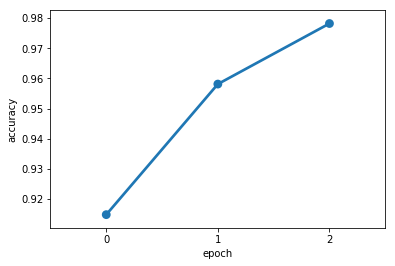

In [6]:
model = BoWClassifier(2, 177012)
model.cuda()

loss_function = nn.NLLLoss(weight=C)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=.001)

test_accuracy = []

for epoch in range(3):
    
    early_stopping_epochs = 2
    
    running_loss = 0.0
    running_obs = 0
    
    for s in range(10):

        loader = get_loader(s)

        for i, data in enumerate(loader, 0):

            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            optimizer.zero_grad()
            
            log_probs = model(inputs)

            loss = loss_function(log_probs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.data[0]
            running_obs += len(data[1])
        
        print('[%d, %5d] loss: %.6f' % (epoch, s, running_loss / running_obs))
        running_loss = 0.0
        running_obs = 0
        
    pred = []
    act = []
    
    for s in range(10, 15):

        loader = get_loader(s)
        
        for data in loader:
            inputs, labels = data
            outputs = model(Variable(inputs).cuda())
            pred += list(outputs[:,1].data)
            act += list(labels)

    fpr, tpr, thresholds = roc_curve(act, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    roc_auc 

    if epoch% 1 == 0:
        print(epoch, ' - Test AUC: %0.6f  %%' % roc_auc)
    test_accuracy.append(roc_auc)
    
    try:
        m = test_accuracy.index(max(test_accuracy))
        t = len(test_accuracy)
        if (t-m) > early_stopping_epochs:
            print('Early Stopping ')
            break
    except:
        pass
    
df = pd.DataFrame(data = {'accuracy' :  test_accuracy, 
                          'epoch':  range(len(test_accuracy))})

sns.pointplot(x='epoch', y='accuracy', data=df)

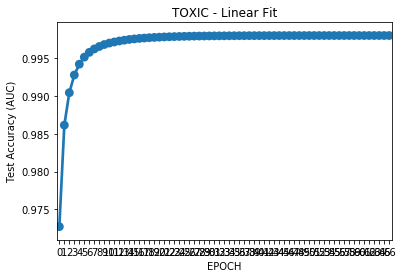

In [53]:
df = pd.DataFrame(data = {'accuracy' :  test_accuracy, 
                          'epoch':  range(len(test_accuracy))})

ax = sns.pointplot(x='epoch', y='accuracy', data=df)
ax.set(xlabel='EPOCH', ylabel='Test Accuracy (AUC)', title='TOXIC - Linear Fit')
plt.savefig('test_fig')

In [7]:
def get_loader_test(start,end):
    X = test_clean.loc[start:end, 'clean_text'].copy()
    X_bow = csr_matrix(vectorizer.transform(X), dtype=np.float32).todense()
    X_tensor = torch.from_numpy(X_bow)
    sset = torch.utils.data.TensorDataset(X_tensor, torch.zeros(len(X)))
    return(torch.utils.data.DataLoader(sset, 
                                       batch_size=100,
                                       shuffle=False, 
                                       num_workers=1))

In [41]:
def create_submission(outfile):

    pred = []
    ids = []

    cuts = np.append(np.arange(0, len(test_clean), 1000), len(test_clean)+1)
    
    for i in range(len(cuts)-1):
    
        loader = get_loader_test(cuts[i], cuts[i+1]-1)

        for data, l in loader:
            inputs = data
            outputs = net(Variable(inputs).cuda())
            pred += list(outputs[:,1].data)
    
    scores = pd.concat([test_clean['id'], pd.Series(p).apply(lambda x: np.exp(x))], axis=1) 
    scores.columns=['id', 'toxic']
    scores.to_csv(outfile)

    return None

In [42]:
p = create_submission(model)

In [57]:
len(test_clean)

153164

In [56]:
scores = pd.concat([test_clean['id'], pd.Series(p).apply(lambda x: np.exp(x))], axis=1) 
scores.columns=['id', 'toxic']
scores.head()

,id,toxic
0,00001cee341fdb12,0.999473
1,0000247867823ef7,0.326178
2,00013b17ad220c46,0.360884
3,00017563c3f7919a,0.016273
4,00017695ad8997eb,0.330229


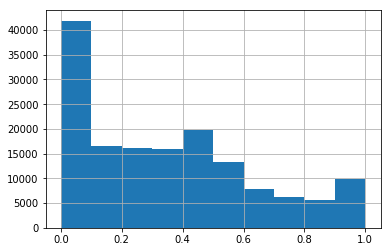

In [55]:
scores.toxic.apply(lambda x: np.exp(x)).hist()

In [38]:
test_clean.loc[0:4, 'clean_text']

0    yo bitch ja rule succesful ever whats hat sad ...
1                                   rfc title fine imo
2                         source zawe ashton lapland —
3    look back source information update correct fo...
4                             anonymously edit article
Name: clean_text, dtype: object

In [40]:
test_clean.loc[5:6, 'clean_text']

5    thank understand think highly would revert wit...
6    please add nonsense wikipedia edits consider v...
Name: clean_text, dtype: object

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [60]:
t0 = time.time()

In [78]:
import time

def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:02.0f}".format(int(hours),int(minutes),round(seconds))

In [81]:
type(timer(t0, time.time()))

str

In [73]:
timer(t0, t1)

'00:02:003.0'

In [84]:
[ x for x in range(int('10'))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [86]:
'fds' not in ['f','g']

True